# Configuración Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ruta_base = "/content/drive/MyDrive/DIMEMEX"

Librerías

In [3]:
import json
import re
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import os
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np
import random
import matplotlib.pyplot as plt


Ordenamiento de datos

In [6]:
with open(f"{ruta_base}/train_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

def extraer_numero(meme_id):
    match = re.search(r'(\d+)', meme_id)
    return int(match.group(1)) if match else 0

datos_ordenados = sorted(data, key=lambda x: extraer_numero(x["MEME-ID"]))

with open(f"{ruta_base}/train_data_sorted.json", "w", encoding="utf-8") as f:
    json.dump(datos_ordenados, f, indent=4, ensure_ascii=False)

df_json = pd.DataFrame(data)
df_json = df_json[["MEME-ID"]]


df_labels = pd.read_csv(f"{ruta_base}/train_labels_tasks_1_3.csv")

df_combined = pd.concat([df_json, df_labels], axis=1)

df_combined.to_csv(f"{ruta_base}/data.csv", index=False, header=False)

df = pd.read_csv(f"{ruta_base}/data.csv", header=None)

Preprocesamiento de datos e imágenes

In [7]:
df.columns = ["MEME-ID", "ninguno", "contenido_inapropiado", "discurso_odio"]

print(df.columns)

# Función para obtener la etiqueta textual según las columnas binarias
def obtener_etiqueta(row):
    if row["discurso_odio"] == 1:
        return "discurso_odio"
    elif row["contenido_inapropiado"] == 1:
        return "contenido_inapropiado"
    elif row["ninguno"] == 1:
        return "ninguno"
    else:
        return "desconocido"

# Aplicar la función a cada fila
df["etiqueta"] = df.apply(obtener_etiqueta, axis=1)

# Nos quedamos solo con MEME-ID y etiqueta
df = df[["MEME-ID", "etiqueta"]]

# Crear diccionario {MEME-ID: etiqueta}
id_to_label = dict(zip(df["MEME-ID"], df["etiqueta"]))

# Función para preprocesar imágenes
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error al cargar: {image_path}")
        return np.zeros((224, 224, 3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

# Función para cargar conjunto de datos desde una carpeta
def load_dataset(directory):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = preprocess_image(img_path)
            images.append(img)

            label = id_to_label.get(filename, None)
            if label is not None:
                labels.append(label)
            else:
                print(f"Advertencia: {filename} no tiene etiqueta.")

    return np.array(images), np.array(labels)

# Cargar datos desde las carpetas de Drive
X_train, y_train = load_dataset(f"{ruta_base}/train")
X_val, y_val = load_dataset(f"{ruta_base}/validation")

# Mostrar formas
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


Index(['MEME-ID', 'ninguno', 'contenido_inapropiado', 'discurso_odio'], dtype='object')
Advertencia: DS_IMG_1212.jpg no tiene etiqueta.
Advertencia: DS_IMG_1660.jpg no tiene etiqueta.
Advertencia: DS_IMG_1688.jpg no tiene etiqueta.
Advertencia: DS_IMG_1570.jpg no tiene etiqueta.
Advertencia: DS_IMG_1470.jpg no tiene etiqueta.
Advertencia: DS_IMG_1347.jpg no tiene etiqueta.
Advertencia: DS_IMG_1631.jpg no tiene etiqueta.
Advertencia: DS_IMG_140.jpg no tiene etiqueta.
Advertencia: DS_IMG_163.jpg no tiene etiqueta.
Advertencia: DS_IMG_1564.jpg no tiene etiqueta.
Advertencia: DS_IMG_1081.jpg no tiene etiqueta.
Advertencia: DS_IMG_1372.jpg no tiene etiqueta.
Advertencia: DS_IMG_1289.jpg no tiene etiqueta.
Advertencia: DS_IMG_1652.jpg no tiene etiqueta.
Advertencia: DS_IMG_1173.jpg no tiene etiqueta.
Advertencia: DS_IMG_130.jpg no tiene etiqueta.
Advertencia: DS_IMG_1287.jpg no tiene etiqueta.
Advertencia: DS_IMG_1441.jpg no tiene etiqueta.
Advertencia: DS_IMG_1232.jpg no tiene etiqueta.
Adv

División del conjunto de datos

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (1810, 224, 224, 3)
y_train shape: (1810,)
X_val shape: (453, 224, 224, 3)
y_val shape: (453,)


Asociación de imágenes con texto

In [9]:
import json

with open(f"{ruta_base}/train_data_sorted.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)

id_to_text = {}

for item in train_data:
    meme_id = item["MEME-ID"]
    text = item["text"]
    id_to_text[meme_id] = text

texts_train = []
for i in range(len(y_train)):
    meme_id = df.iloc[i]["MEME-ID"]
    text = id_to_text.get(meme_id, "")
    texts_train.append(text)

texts_train = np.array(texts_train)

texts_val = []
for i in range(len(y_val)):
    meme_id = df.iloc[i]["MEME-ID"]
    text = id_to_text.get(meme_id, "")
    texts_val.append(text)

texts_val = np.array(texts_val)


Construcción del modelo multimodal

In [10]:
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Lambda

#tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#parámetros
MAX_LEN = 64  #máxima longitud del texto tokenizado

#imagen
image_input = Input(shape=(224, 224, 3), name="image_input")

#texto (lo vamos a tokenizar antes de alimentar a BERT)
text_input = Input(shape=(MAX_LEN,), dtype=tf.int32, name="text_input")
attention_mask_input = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask_input")

vgg = VGG16(include_top=False, weights="imagenet", input_tensor=image_input)
for layer in vgg.layers:
    layer.trainable = False  #congelamos VGG16

x_image = layers.Flatten()(vgg.output)
x_image = layers.Dense(256, activation="relu")(x_image)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def bert_layer(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output  # <- (batch_size, 768)

x_text = Lambda(bert_layer, output_shape=(768,))([text_input, attention_mask_input])
x_text = layers.Dense(256, activation="relu")(x_text)

combined = layers.concatenate([x_image, x_text])
z = layers.Dense(128, activation="relu")(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(3, activation="softmax")(z)  #3 clases

model = Model(inputs=[image_input, text_input, attention_mask_input], outputs=output)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 21,400,387 (81.64 MB)

 Trainable params: 6,685,699 (25.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Filtrado y codificación

In [ ]:
import numpy as np

X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val,   dtype=np.float32)

label_map = {
    "discurso_odio":            0,
    "contenido_inapropiado":    1,
    "ninguno":                  2
}

X_train_filt, texts_train_filt, y_train_filt = [], [], []
for img, txt, lbl in zip(X_train, texts_train, y_train):
    if lbl in label_map:                   # solo guardamos si lbl está en el mapa
        X_train_filt.append(img)
        texts_train_filt.append(txt)
        y_train_filt.append(lbl)

X_train = np.array(X_train_filt, dtype=np.float32)
texts_train = texts_train_filt        # seguimos pasándolo a tokenizar más adelante
y_train = np.array(y_train_filt)      # strings, por ahora

X_val_filt, texts_val_filt, y_val_filt = [], [], []
for img, txt, lbl in zip(X_val, texts_val, y_val):
    if lbl in label_map:
        X_val_filt.append(img)
        texts_val_filt.append(txt)
        y_val_filt.append(lbl)

X_val   = np.array(X_val_filt, dtype=np.float32)
texts_val = texts_val_filt
y_val   = np.array(y_val_filt)


#ahora sí todo el contenido de y_train/y_val está en label_map
y_train = np.array([ label_map[l] for l in y_train ], dtype=np.int32)
y_val   = np.array([ label_map[l] for l in y_val   ], dtype=np.int32)

# Verifica que solo haya 0,1,2
print("Clases train:", np.unique(y_train))
print("Clases val:  ", np.unique(y_val))

Clases en train: [0 1 2]
Clases en val:   [0 1 2]


Tokenización de texto

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    list(texts_train),
    truncation=True,
    padding='max_length',
    max_length=64,
    return_tensors='tf'
)

val_encodings = tokenizer(
    list(texts_val),
    truncation=True,
    padding='max_length',
    max_length=64,
    return_tensors='tf'
)

X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)

y_train = np.array(y_train).astype(np.int32)
y_val = np.array(y_val).astype(np.int32)

train_inputs = {
    "image_input": X_train,
    "text_input": train_encodings['input_ids'],
    "attention_mask_input": train_encodings['attention_mask']
}

val_inputs = {
    "image_input": X_val,
    "text_input": val_encodings['input_ids'],
    "attention_mask_input": val_encodings['attention_mask']
}

Entrenamiento

In [13]:
model.fit(
    train_inputs,
    y_train,
    validation_data=(val_inputs, y_val),
    epochs=5,
    batch_size=64
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4797 - loss: 2.0843 - val_accuracy: 0.6150 - val_loss: 0.9999
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.6096 - loss: 0.9424 - val_accuracy: 0.6040 - val_loss: 0.9547
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 752ms/step - accuracy: 0.6576 - loss: 0.8360 - val_accuracy: 0.5973 - val_loss: 0.9493
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 661ms/step - accuracy: 0.6565 - loss: 0.8026 - val_accuracy: 0.6150 - val_loss: 0.9472
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 742ms/step - accuracy: 0.7196 - loss: 0.6970 - val_accuracy: 0.5841 - val_loss: 1.0047


Prueba individual

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


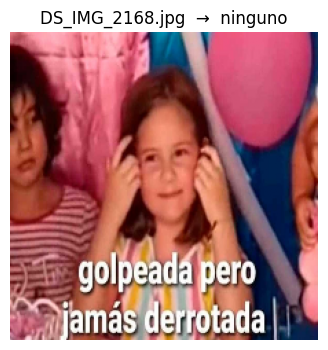

In [15]:
# === Ruta base en Google Drive ===
ruta_base = "/content/drive/MyDrive/DIMEMEX"
val_dir = os.path.join(ruta_base, "validation")

# 1) Listar y escoger un archivo al azar
val_files = [f for f in os.listdir(val_dir) if f.lower().endswith((".jpg", ".png"))]
random_file = random.choice(val_files)
img_path = os.path.join(val_dir, random_file)

# 2) Preprocesar imagen
img = preprocess_image(img_path)
img_batch = np.expand_dims(img, axis=0)

# 3) Obtener texto
text = id_to_text.get(random_file, "")

# 4) Tokenizar texto
enc = tokenizer(
    text,
    truncation=True,
    padding="max_length",
    max_length=64,
    return_tensors="tf"
)
input_ids = enc["input_ids"]
attn_mask = enc["attention_mask"]

# 5) Predicción
preds = model.predict({
    "image_input": img_batch,
    "text_input": input_ids,
    "attention_mask_input": attn_mask
})
pred_class = int(np.argmax(preds, axis=1)[0])

# 6) Mapear clase a etiqueta
label_map_rev = {0: "discurso_odio", 1: "contenido_inapropiado", 2: "ninguno"}
pred_label = label_map_rev[pred_class]

# 7) Mostrar imagen con predicción
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"{random_file}  →  {pred_label}", fontsize=12)
plt.show()

Evaluación

In [16]:
# Predecir todas las etiquetas del conjunto de validación
y_pred_probs = model.predict(val_inputs)
y_pred = np.argmax(y_pred_probs, axis=1)  # clases predichas (índices)

# y_val deben estar como enteros: 0, 1, 2
# Si no lo están, asegúrate de convertirlos
if isinstance(y_val[0], str):
    label_map = {"discurso_odio": 0, "contenido_inapropiado": 1, "ninguno": 2}
    y_val = np.array([label_map[label] for label in y_val])

# Calcular F1 score macro y weighted
f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 461ms/step
F1 Score (macro): 0.2950
F1 Score (weighted): 0.4896
